In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd
add_folders=["/home/edlitzy/PycharmProjects/UKBB"]
sys.path.extend([x for x in add_folders if x not in sys.path])
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay

# load data

In [2]:
data_path="/net/mraid08/export/jafar/UKBioBank/Data/Clalit/Clalit_bt.csv"
save_final_df_path="/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/revision/clalit/scoreboard_results/141121_results.csv"
orig_clalit_df=pd.read_csv(filepath_or_buffer=data_path,index_col="pid")
rel_ind=orig_clalit_df["Reticulocyte Count"].dropna().index
orig_clalit_df=orig_clalit_df.loc[rel_ind,:]

In [3]:
orig_clalit_df

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count
pid,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.400000,48.0,129.0,NaN,42.076650,0.062400
5277,2011-01-16,5.6,1933-06-04,1.0,31.0,0.052000,41.0,157.0,NaN,37.705050,0.000052
5374,2006-10-29,6.3,1933-03-05,1.0,433.0,19.200001,69.0,65.0,NaN,45.355352,0.019200
6330,2009-02-19,5.1,1935-09-02,0.0,32.0,204.700000,37.0,209.0,2016-05-26,32.240550,0.204700
7918,2011-03-20,5.4,1938-08-26,1.0,81.0,67.000000,51.0,105.0,2017-08-06,35.519250,0.067000
...,...,...,...,...,...,...,...,...,...,...,...
10056438,2010-07-19,6.1,1938-06-13,0.0,15.0,68.000000,35.0,130.0,NaN,43.169550,0.068000
10064594,2011-11-13,5.5,1948-09-08,1.0,97.0,168.000000,39.0,60.0,NaN,36.612150,0.168000
10066521,2011-11-27,5.2,1947-01-29,0.0,71.0,65.600000,32.0,53.0,NaN,33.333450,0.065600


# Convert data to dateime

In [4]:
non_na_ind=orig_clalit_df["diabetes_date"].dropna().index
orig_clalit_df.loc[:,["first_visit","datetime_leida"]]=orig_clalit_df.loc[:,["first_visit","datetime_leida"]].applymap(datetime.fromisoformat)
orig_clalit_df.loc[non_na_ind,["diabetes_date"]]=orig_clalit_df.loc[non_na_ind,["diabetes_date"]].applymap(datetime.fromisoformat)

In [5]:
(((orig_clalit_df["first_visit"]-orig_clalit_df["datetime_leida"])/365.25)>timedelta(days=70)).sum()

1010

In [6]:
clalit_df=orig_clalit_df.copy()
clalit_df=clalit_df.loc[(((clalit_df["first_visit"]-clalit_df["datetime_leida"])/365.25)<=timedelta(days=70)),:]

In [7]:
clalit_df=clalit_df.loc[(((clalit_df["first_visit"]-clalit_df["datetime_leida"])/365.25)>=timedelta(days=40)),:]

# Draw a delta time till return

In [8]:
mean_dt=7.3
sigma=2.3
max_dt=17
min_dt=2
clalit_df["dt_years"]=np.clip(np.random.normal(mean_dt,sigma,size=clalit_df.shape[0]),a_max=max_dt,a_min=min_dt)

In [9]:
def my_relative_delta(row):
    print(row)
    return row["first_visit"].replace(year=row["first_visit"].year + row["dt_years"])

In [10]:
pd.to_timedelta(365*clalit_df["dt_years"], unit='D')
clalit_df["dt_days"]=pd.to_timedelta(365*clalit_df["dt_years"], unit='D')
clalit_df["check_date"]=(clalit_df["first_visit"]+ clalit_df["dt_days"]).clip(upper=datetime.fromisoformat("2019-12-31"))

<AxesSubplot:>

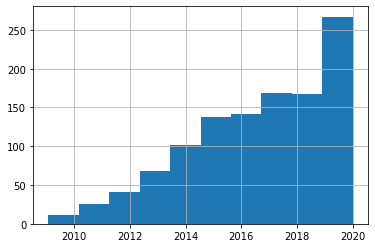

In [11]:
clalit_df["check_date"].hist()

In [12]:
clalit_df["final_dt"]=clalit_df["check_date"]-clalit_df["first_visit"]

<AxesSubplot:ylabel='Frequency'>

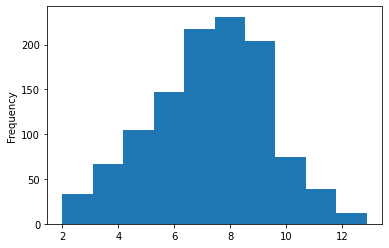

In [13]:
(clalit_df["final_dt"].astype('timedelta64[D]')/365).plot.hist()

In [14]:
(clalit_df["final_dt"].astype('timedelta64[D]')/365).mean()

7.273339238263951

In [15]:
clalit_df["diabetes_date"].isna()

pid
3485         True
11430        True
24485        True
47490        True
52237       False
            ...  
9890555      True
9892371      True
10048398     True
10064594     True
10066521     True
Name: diabetes_date, Length: 1129, dtype: bool

# def check_diagnose

In [16]:
def check_diagnose(row):
#     print(row)
    if type(row["diabetes_date"]) is float:
        return 0
    elif row["diabetes_date"]>row["check_date"]:
        return 0
    elif row["diabetes_date"]<=row["check_date"]:
        return 1
    else:
        return np.nan

In [17]:
clalit_df["Y"]=clalit_df.apply(check_diagnose,axis=1)

# T2D Prevalence at time of test

In [18]:
clalit_df["Y"].sum()/clalit_df.shape[0]

0.20992028343666963

In [19]:
clalit_df.head()

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y
pid,,,,,,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.4,48.0,129.0,NaN,42.07665,0.0624,7.334631,2677 days 03:22:05.662934400,2018-01-03 03:22:05.662934400,2677 days 03:22:05.662934400,0
11430,2011-09-18,6.0,1942-04-25,1.0,16.0,74.5,45.0,75.0,NaN,42.07665,0.0745,9.934703,3626 days 03:59:54.500928,2019-12-31 00:00:00.000000000,3026 days 00:00:00,0
24485,2011-07-10,5.0,1943-02-24,1.0,19.0,107.6,49.0,144.0,NaN,31.14765,0.1076,4.141959,1511 days 19:33:32.808902400,2015-08-29 19:33:32.808902400,1511 days 19:33:32.808902400,0
47490,2008-08-06,6.0,1940-05-27,1.0,32.0,51.5,36.0,94.0,NaN,42.07665,0.0515,5.696537,2079 days 05:39:39.229603200,2014-04-16 05:39:39.229603200,2079 days 05:39:39.229603200,0
52237,2011-12-04,4.3,1950-05-13,1.0,21.0,85.0,40.0,89.0,2012-07-30 00:00:00,23.49735,0.0850,8.732739,3187 days 10:47:51.880819200,2019-12-31 00:00:00.000000000,2949 days 00:00:00,1


<AxesSubplot:>

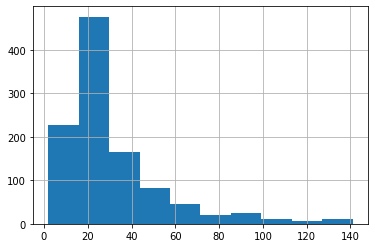

In [20]:
clalit_df.loc[clalit_df["GGT"]<clalit_df["GGT"].quantile(0.95),"GGT"].hist()

In [21]:
clalit_df.columns

Index(['first_visit', 'HbA1c%', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'diabetes_date',
       'UKB_HbA1c', 'UKB_reticulocyte_count', 'dt_years', 'dt_days',
       'check_date', 'final_dt', 'Y'],
      dtype='object')

In [22]:
clalit_df["UKB_Triglycerides"]=clalit_df["Triglycerides"]*0.01129

In [23]:
clalit_df["UKB_HDL"]=clalit_df["HDL"]*0.02586

In [24]:
rel_cols=[x for x in clalit_df.columns if x!="diabetes_date"]

In [25]:
non_na_ind=clalit_df[rel_cols].dropna(how="any").index

In [26]:
final_df=clalit_df.loc[non_na_ind,:]

In [27]:
final_df.isna().sum()

first_visit                 0
HbA1c%                      0
datetime_leida              0
is_male                     0
GGT                         0
Reticulocyte Count          0
HDL                         0
Triglycerides               0
diabetes_date             822
UKB_HbA1c                   0
UKB_reticulocyte_count      0
dt_years                    0
dt_days                     0
check_date                  0
final_dt                    0
Y                           0
UKB_Triglycerides           0
UKB_HDL                     0
dtype: int64

# Build scoreboard

<AxesSubplot:>

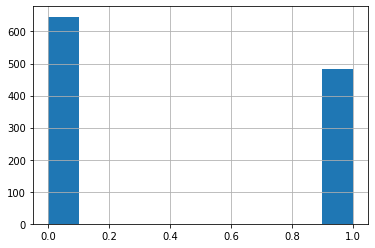

In [28]:
final_df["is_male"].hist()

In [29]:
def check_sex(row):
    if row["is_male"]==1:
        return 3
    elif row["is_male"]==0:
        return 0
    else:
        print("is_male should be 0 or 1")

<AxesSubplot:ylabel='Frequency'>

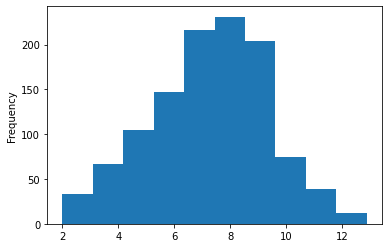

In [30]:
(final_df["final_dt"].astype('timedelta64[D]')/365).plot.hist()

In [32]:
def check_dt(row):
    factor=365.25
    dt=row["final_dt"]
    if dt<=timedelta(days=factor*5):
        return 0
    elif dt<=timedelta(days=factor*6):
        return 8
    elif dt<=timedelta(days=factor*8):
        return 11
    elif dt<=timedelta(days=factor*9):
        return 12
    elif dt<=timedelta(days=factor*10):
        return 16
    elif dt>timedelta(days=factor*10):
        return 20
    else:
        print("dt must be a timedelta object")
        return None

<AxesSubplot:>

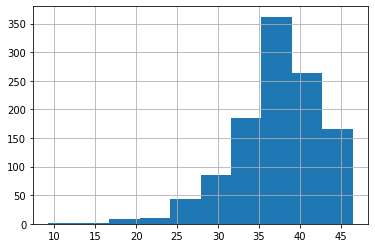

In [33]:
final_df["UKB_HbA1c"].hist()

In [34]:
def check_a1c(row):
    val=row["UKB_HbA1c"]
    if val<=30.7:
        return 0
    elif val<=32.4:
        return 11
    elif val<=33.6:
        return 15
    elif val<=34.6:
        return 17
    elif val<=35.7:
        return 26
    elif val<=36.9:
        return 31
    elif val<=38.5:
        return 38
    elif val>38.5:
        return 57
    else:
        print("a1c is not in any range")
        return None

<AxesSubplot:>

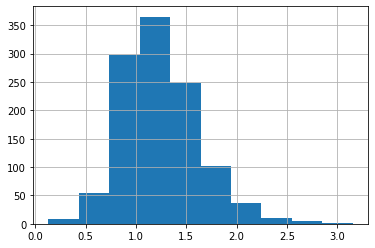

In [35]:
final_df["UKB_HDL"].hist()

In [36]:
def check_hdl(row):
    val=row["UKB_HDL"]
    if val<=1.1:
        return 29
    elif val<=1.3:
        return 21
    elif val<=1.4:
        return 20
    elif val<=1.5:
        return 15
    elif val<=1.6:
        return 13
    elif val<=1.9:
        return 10 
    elif val>1.9:
        return 0
    else:
        print("HDL is not in any range")
        return None

<AxesSubplot:>

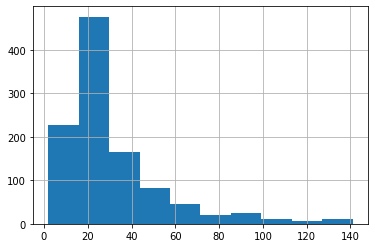

In [37]:
final_df.loc[final_df["GGT"]<final_df["GGT"].quantile(0.95),"GGT"].hist()

In [38]:
def check_ggt(row):
    val=row["GGT"]
    if val<=14.8:
        return 0
    elif val<=18:
        return 8
    elif val<=21.4:
        return 12
    elif val<=25.3:
        return 14
    elif val<=30.4:
        return 19
    elif val<=37.7:
        return 23
    elif val<=53.3:
        return 26
    elif val>53.3:
        return 28
    else:
        print("GGT is not in any range")
        return None

In [41]:
#final_df.loc[final_df["UKB_reticulocyte_count"]<final_df["UKB_reticulocyte_count"].quantile(0.95),"UKB_reticulocyte_count"].hist()

In [42]:
# def check_reticulocyte(row):
#     val=row["UKB_reticulocyte_count"]
#     if val<=0.035:
#         return 0
#     elif val<=0.043:
#         return 5
#     elif val<=0.051:
#         return 7
#     elif val<=0.058:
#         return 11
#     elif val<=0.067:
#         return 14
#     elif val<=0.081:
#         return 17
#     elif val>0.081:
#         return 22
#     else:
#         print("reticulocyte is not in any range")
#         return None

<AxesSubplot:>

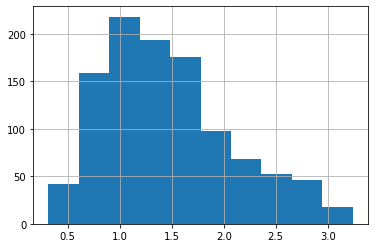

In [43]:
final_df.loc[final_df["UKB_Triglycerides"]<final_df["UKB_Triglycerides"].quantile(0.95),"UKB_Triglycerides"].hist()

In [44]:
def check_triglycerides(row):
    val=row["UKB_Triglycerides"]
    if val<=0.89:
        return 0
    elif val<=1.2:
        return 6
    elif val<=1.4:
        return 7
    elif val<=1.8:
        return 11
    elif val<=2.4:
        return 13
    elif val>2.4:
        return 16
    else:
        print("triglycerides is not in any range")
        return None

In [45]:
def scoreboard_score(row):
#     print(row)
    tot_sum=0
    func_list=[check_sex,check_dt,check_a1c,check_hdl,check_ggt,check_triglycerides]
    for func in func_list:
        tot_sum+=func(row)
    return tot_sum

In [46]:
final_df.isna().sum()

first_visit                 0
HbA1c%                      0
datetime_leida              0
is_male                     0
GGT                         0
Reticulocyte Count          0
HDL                         0
Triglycerides               0
diabetes_date             822
UKB_HbA1c                   0
UKB_reticulocyte_count      0
dt_years                    0
dt_days                     0
check_date                  0
final_dt                    0
Y                           0
UKB_Triglycerides           0
UKB_HDL                     0
dtype: int64

In [47]:
final_df.shape

(1128, 18)

## Save Final DF

In [48]:
final_df["score"]=final_df.apply(scoreboard_score,axis=1)

In [49]:
final_df.to_csv(save_final_df_path)

<AxesSubplot:>

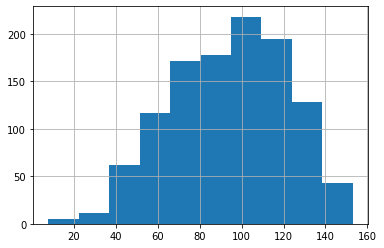

In [50]:
final_df["score"].hist()

In [51]:
final_df.head()

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
3485,2010-09-05,6.0,1946-04-02,0.0,11.0,62.4,48.0,129.0,NaN,42.07665,0.0624,7.334631,2677 days 03:22:05.662934400,2018-01-03 03:22:05.662934400,2677 days 03:22:05.662934400,0,1.45641,1.24128,100
11430,2011-09-18,6.0,1942-04-25,1.0,16.0,74.5,45.0,75.0,NaN,42.07665,0.0745,9.934703,3626 days 03:59:54.500928,2019-12-31 00:00:00.000000000,3026 days 00:00:00,0,0.84675,1.16370,101
24485,2011-07-10,5.0,1943-02-24,1.0,19.0,107.6,49.0,144.0,NaN,31.14765,0.1076,4.141959,1511 days 19:33:32.808902400,2015-08-29 19:33:32.808902400,1511 days 19:33:32.808902400,0,1.62576,1.26714,58
47490,2008-08-06,6.0,1940-05-27,1.0,32.0,51.5,36.0,94.0,NaN,42.07665,0.0515,5.696537,2079 days 05:39:39.229603200,2014-04-16 05:39:39.229603200,2079 days 05:39:39.229603200,0,1.06126,0.93096,126
52237,2011-12-04,4.3,1950-05-13,1.0,21.0,85.0,40.0,89.0,2012-07-30 00:00:00,23.49735,0.0850,8.732739,3187 days 10:47:51.880819200,2019-12-31 00:00:00.000000000,2949 days 00:00:00,1,1.00481,1.03440,62


# ROC and APS

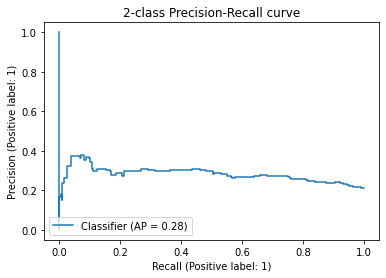

In [52]:
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay
PR_disp=PrecisionRecallDisplay.from_predictions(final_df["Y"],final_df["score"])
_ = PR_disp.ax_.set_title("2-class Precision-Recall curve")

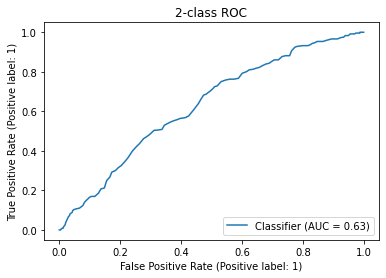

In [53]:
ROC_disp=RocCurveDisplay.from_predictions(final_df["Y"],final_df["score"])
_ = ROC_disp.ax_.set_title("2-class ROC")

In [54]:
final_df.columns

Index(['first_visit', 'HbA1c%', 'datetime_leida', 'is_male', 'GGT',
       'Reticulocyte Count', 'HDL', 'Triglycerides', 'diabetes_date',
       'UKB_HbA1c', 'UKB_reticulocyte_count', 'dt_years', 'dt_days',
       'check_date', 'final_dt', 'Y', 'UKB_Triglycerides', 'UKB_HDL', 'score'],
      dtype='object')

In [55]:
view_df=final_df.loc[:,['first_visit',"diabetes_date",'final_dt','check_date','Y','score']].sort_values(by="score")

In [56]:
final_df=final_df.sort_values(by="score")

In [57]:
final_df.loc[final_df["Y"]==1,:].head(50)

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
4427284,2008-11-04,4.40,1962-12-31,0.0,12.0,86.700000,54.0,51.0,2012-01-30 00:00:00,24.590250,0.086700,6.367673,2324 days 04:48:43.162847999,2015-03-17 04:48:43.162847999,2324 days 04:48:43.162847999,1,0.57579,1.39644,31
2893236,2009-09-16,4.90,1950-02-12,0.0,13.0,0.071900,37.0,210.0,2013-04-12 00:00:00,30.054750,0.000072,4.790601,1748 days 13:40:01.631366400,2014-06-30 13:40:01.631366400,1748 days 13:40:01.631366400,1,2.37090,0.95682,42
3797282,2007-11-06,4.60,1951-08-09,0.0,11.0,66.000000,44.0,85.0,2019-05-14 00:00:00,26.776050,0.066000,11.775417,4298 days 00:39:25.504128,2019-08-13 00:39:25.504128000,4298 days 00:39:25.504128,1,0.95965,1.13784,47
537062,2009-08-17,5.09,1944-01-07,0.0,18.0,82.000000,68.0,120.0,2015-01-13 00:00:00,32.131260,0.082000,6.360471,2321 days 13:43:31.287964800,2015-12-25 13:43:31.287964800,2321 days 13:43:31.287964800,1,1.35480,1.75848,47
813015,2009-02-23,4.90,1947-02-13,1.0,23.0,120.000000,46.0,153.0,2010-04-11 00:00:00,30.054750,0.120000,2.856342,1042 days 13:33:18.725616,2012-01-01 13:33:18.725616000,1042 days 13:33:18.725616,1,1.72737,1.18956,49
9211665,2008-04-30,4.90,1950-11-25,0.0,74.0,54.000000,47.0,74.0,2008-08-13 00:00:00,30.054750,0.054000,4.678835,1707 days 18:35:50.092425600,2013-01-01 18:35:50.092425600,1707 days 18:35:50.092425600,1,0.83546,1.21542,49
5110727,2011-12-15,5.20,1958-05-20,0.0,25.0,14.000000,57.0,123.0,2013-07-11 00:00:00,33.333450,0.014000,4.816836,1758 days 03:28:58.354608,2016-10-07 03:28:58.354608000,1758 days 03:28:58.354608,1,1.38867,1.47402,51
4744037,2006-02-16,5.10,1949-06-10,0.0,25.0,119.000000,55.0,76.0,2009-08-26 00:00:00,32.240549,0.119000,8.186970,2988 days 05:51:27.466300800,2014-04-23 05:51:27.466300800,2988 days 05:51:27.466300800,1,0.85804,1.42230,52
1351633,2007-10-16,4.80,1940-02-19,0.0,40.0,42.400000,38.0,77.0,2009-03-08 00:00:00,28.961850,0.042400,2.426405,885 days 15:18:42.783897600,2010-03-19 15:18:42.783897600,885 days 15:18:42.783897600,1,0.86933,0.98268,55


In [58]:
final_df.loc[final_df["Y"]==0,:].tail(5)

,first_visit,HbA1c%,datetime_leida,is_male,GGT,Reticulocyte Count,HDL,Triglycerides,diabetes_date,UKB_HbA1c,UKB_reticulocyte_count,dt_years,dt_days,check_date,final_dt,Y,UKB_Triglycerides,UKB_HDL,score
pid,,,,,,,,,,,,,,,,,,,
3802410,2008-04-02,6.1,1951-09-18,0.0,63.0,39.0,24.0,138.0,NaN,43.169550,0.0390,10.231823,3734 days 14:46:18.612393600,2018-06-23 14:46:18.612393600,3734 days 14:46:18.612393600,0,1.55802,0.62064,145
4151047,2007-07-01,5.9,1957-07-27,1.0,86.0,42.0,41.0,249.0,NaN,40.983750,0.0420,9.285967,3389 days 09:04:24.974803200,2016-10-10 09:04:24.974803200,3389 days 09:04:24.974803200,0,2.81121,1.06026,149
1523814,2009-08-25,5.7,1940-03-07,1.0,162.0,29.0,8.0,261.0,NaN,38.797950,0.0290,9.748563,3558 days 05:24:56.319494400,2019-05-23 05:24:56.319494400,3558 days 05:24:56.319494400,0,2.94669,0.20688,149
4141416,2009-03-16,6.1,1957-05-24,1.0,73.0,85.3,25.0,168.0,NaN,43.169550,0.0853,10.890212,3974 days 22:15:20.543299200,2019-12-31 00:00:00.000000000,3942 days 00:00:00,0,1.89672,0.64650,150
9205236,2006-01-24,6.4,1946-03-16,1.0,66.0,3.0,42.0,230.0,NaN,46.448251,0.0030,10.158127,3707 days 17:11:35.290579200,2016-03-19 17:11:35.290579200,3707 days 17:11:35.290579200,0,2.59670,1.08612,153
